In [2]:
import numpy as np
import os

import matplotlib.pyplot as plt

aac1
maximum_wire_lifetime = 7.4 ns
0.28746813392186166
maximum_wire_lifetime = 1.0 ns
0.2950286725351503
maximum_wire_lifetime = 0.7 ns
0.29505904922484616
maximum_wire_lifetime = 0.0 ns
0.3931844492977726
maximum_wire_lifetime = 0.4 ns
0.30423153164070715
maximum_wire_lifetime = 11.600000000000001 ns
0.2872578375722167


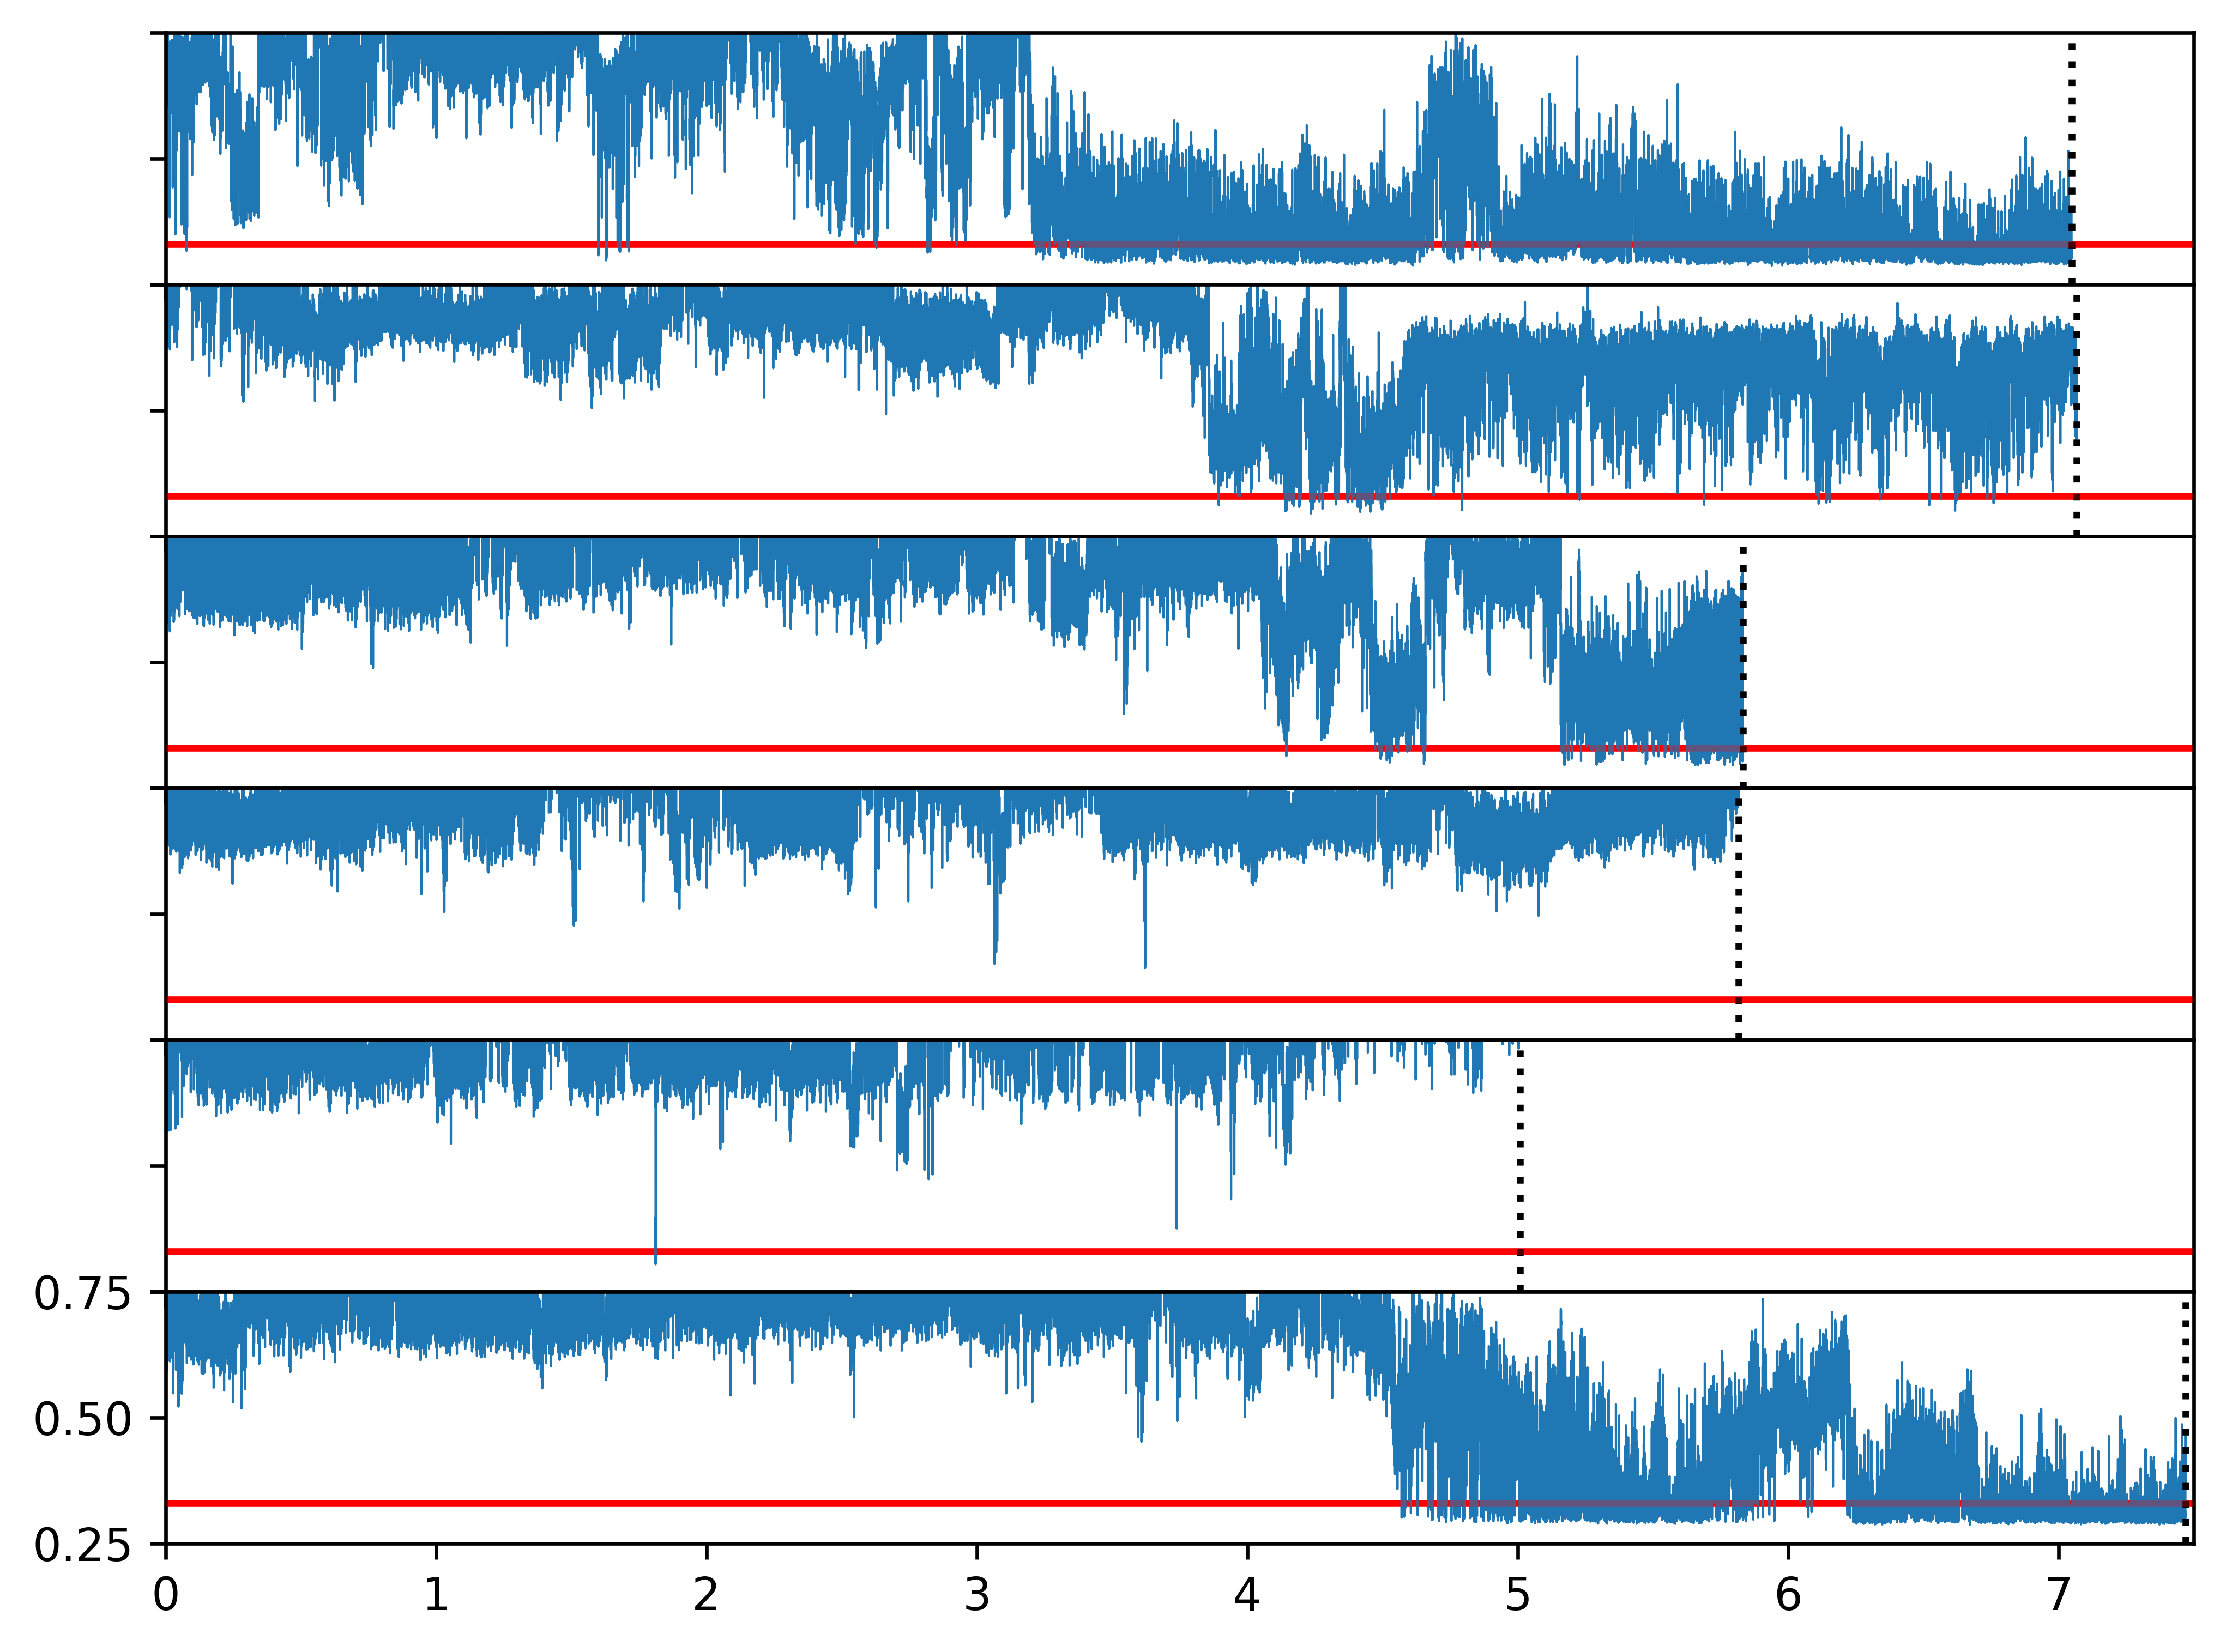

[0.24257987628397934, 0.0033110708625764093, 0.005709387055293613, 0.0, 0.0001197939543984347, 0.1719097212926026]
wire forms 0.0706+=0.0988 of the time
ucp1
maximum_wire_lifetime = 0.6000000000000001 ns
0.3029336762941896
maximum_wire_lifetime = 0.6000000000000001 ns
0.3046327944806131
maximum_wire_lifetime = 0.1 ns
0.3182108270433367
maximum_wire_lifetime = 1.6 ns
0.2896653789219253
maximum_wire_lifetime = 0.4 ns
0.302240101755624
maximum_wire_lifetime = 0.4 ns
0.2972373837103424


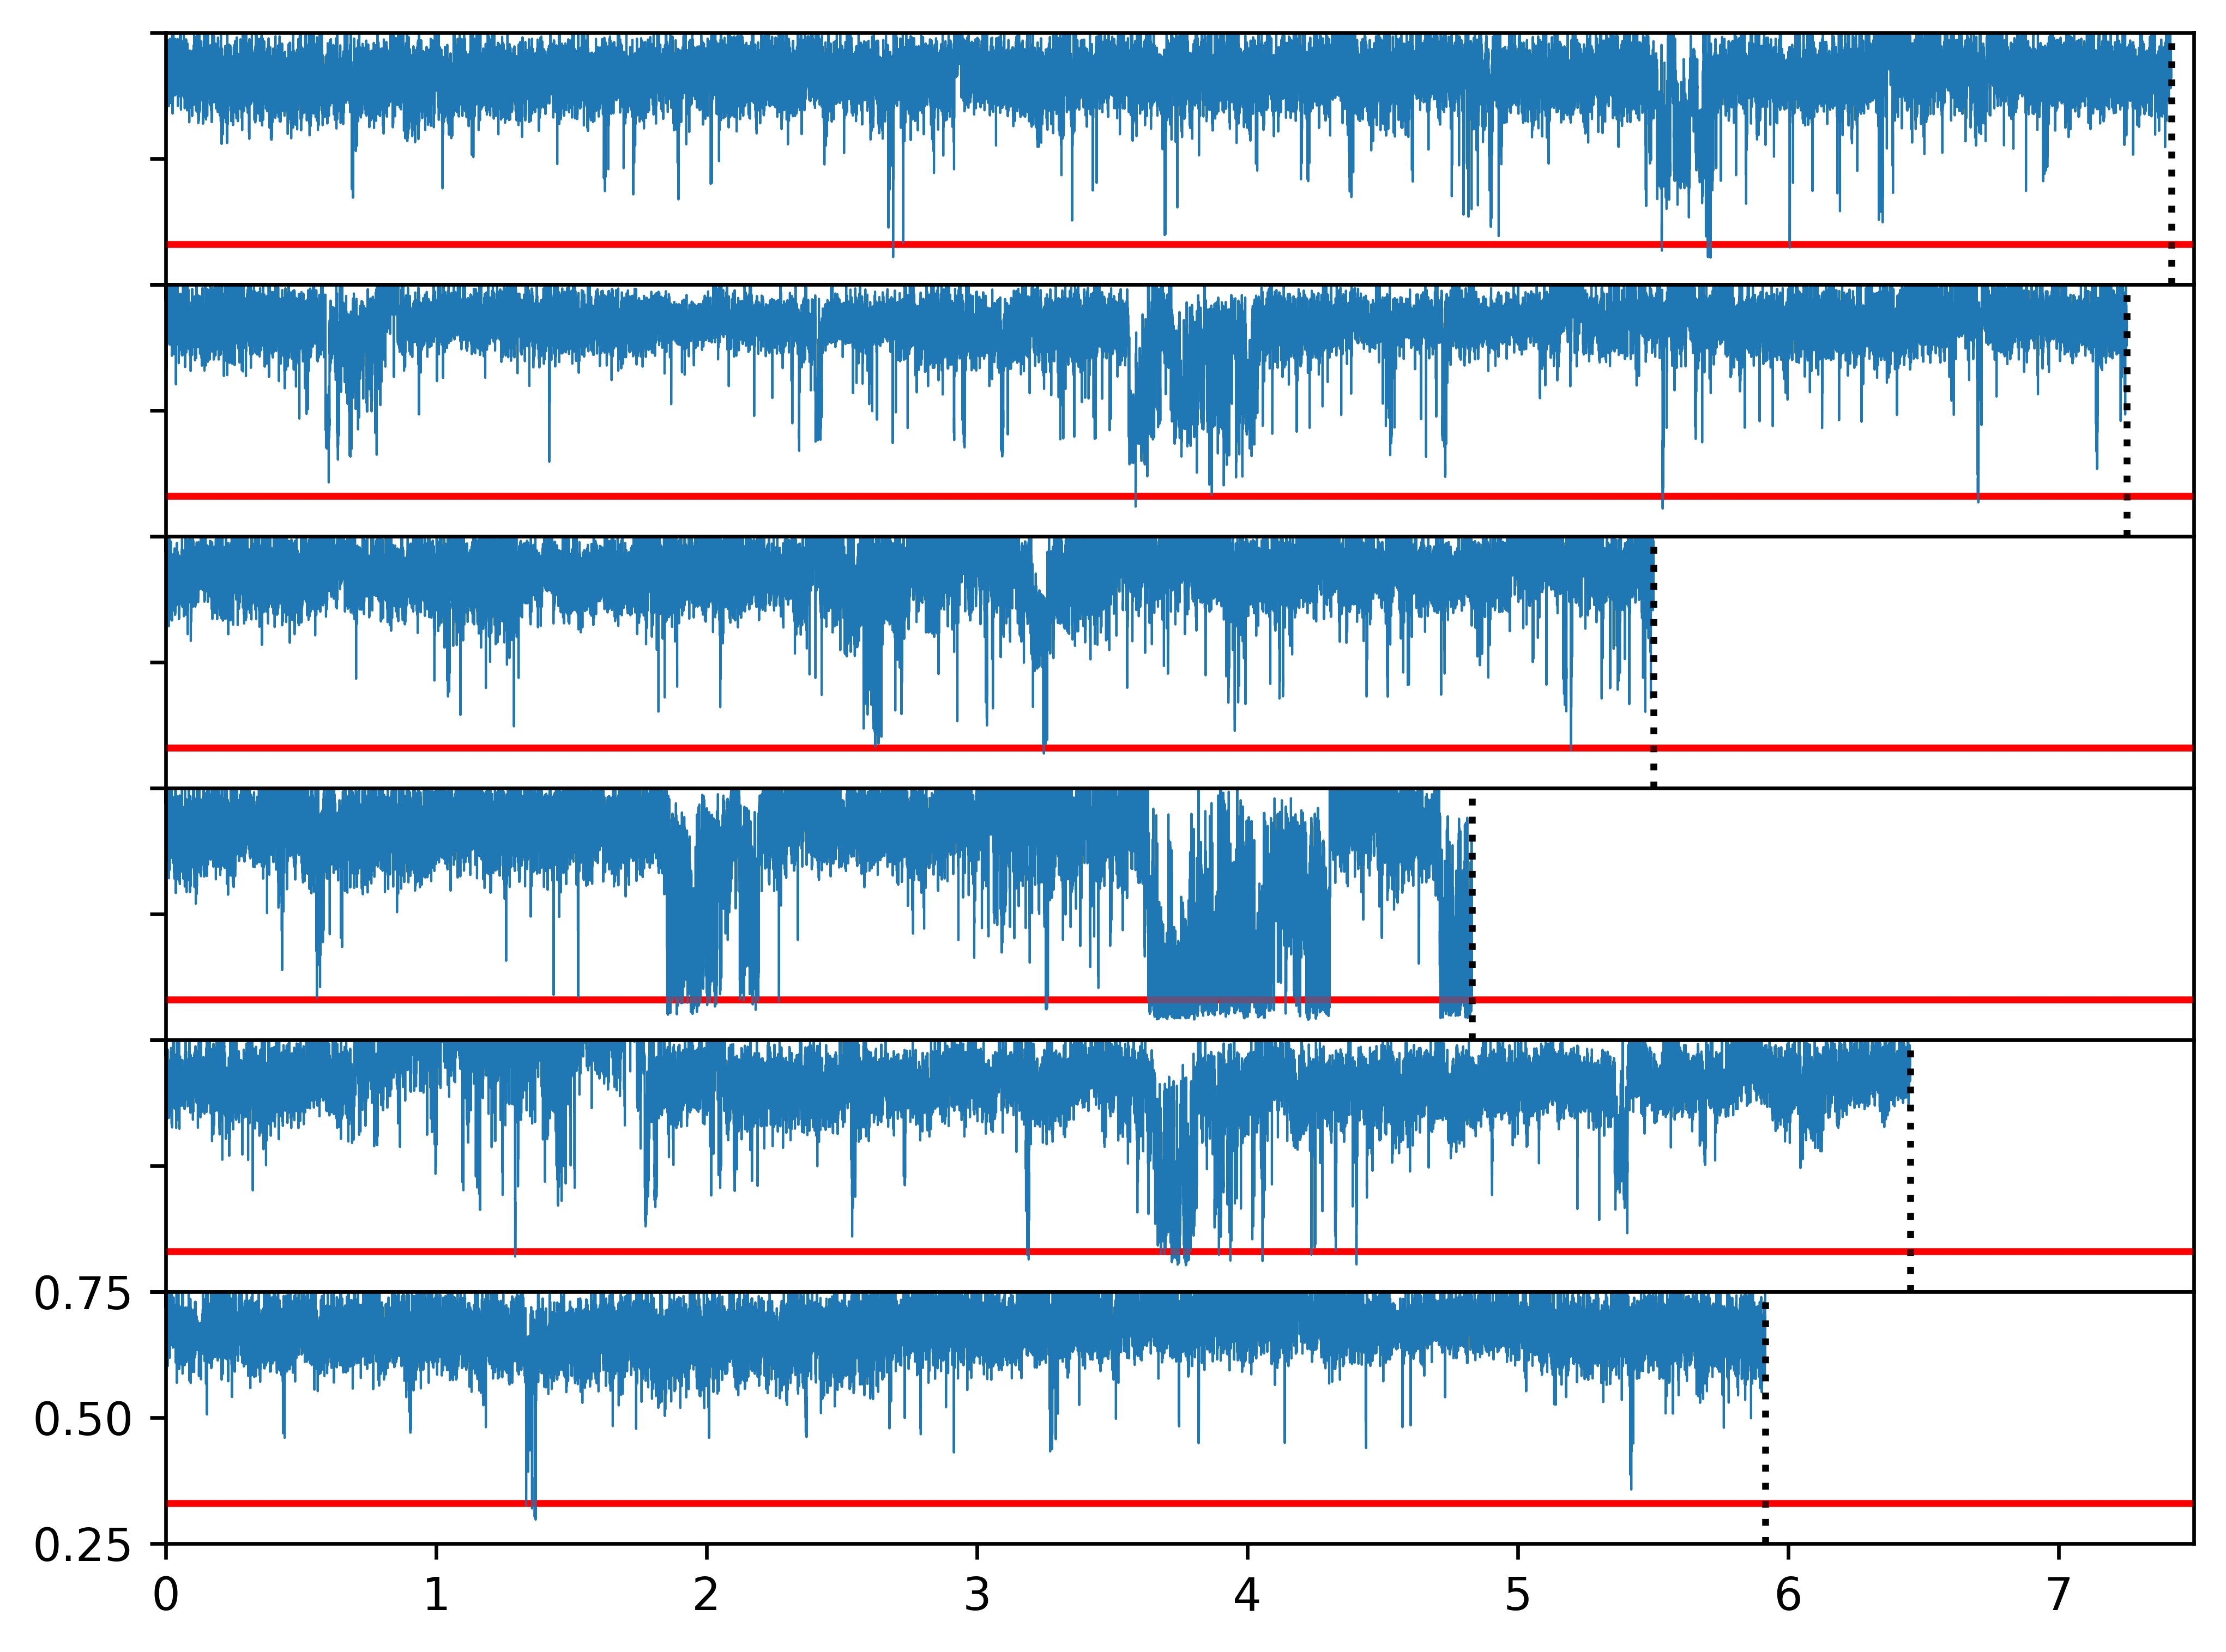

[0.00026965807356272247, 0.0002205983730869985, 3.634645440337295e-05, 0.029497609141153822, 0.0013020833333333333, 0.0002366703857727288]
wire forms 0.0053+=0.0108 of the time


In [4]:
window = 500
threshold = 0.33
colors = ["cyan", "orange", "green", "red", "purple", "grey"]

freqplot = False
multiplot = True

def compile_wire_data():

    #inputpath = "/media/X01Raid01/Data_Backup/home/jborowsky/long-sims/long-aac1-ucp1-processing/water_wires"
    inputpath = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/water_wires"

    servers = ["wynton", "degrabo"]
    proteins = ["aac1", "ucp1"]

    #loop over servers, proteins, and parallel runs
    for protein in proteins:
        print(protein)
        wire_fractions = []
        legend = []
        ci = 0

        if not multiplot:
            plt.figure(figsize = (15,6), dpi=600)

        else:
            fig = plt.figure(figsize = (8,6), dpi=600)
            gs = fig.add_gridspec(6, hspace=0) #-0.2 works otherwise
            axs = gs.subplots(sharex=True, sharey=True)

        # fig.suptitle('Sharing both axes')
        # axs[0].plot(x, y ** 2)
        # axs[1].plot(x, 0.3 * y, 'o')
        # axs[2].plot(x, y, '+')

        #pml_out_lines = ["delete all\n", f"load /home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/long-aac1-ucp1-processing/wynton/{protein}/input/seg_0035.gro\n"] 
        for server in servers:
            #toppath = f"{inputpath}/{server}/{protein}/input/seg_0035.gro"
            for run in range(1,5):
                if server == "degrabo" and run > 2:
                    continue

                #segments are named differently on different servers
                if server == "wynton":
                    segs = ["001"]+[str(i) for i in range(100, 1000, 100)]
                elif server == "degrabo":
                    segs = [str(i).zfill(3) for i in range(1,20)]
                else:
                    segs = [] #ensure variable is defined

                #step is in microseconds
                if server == "wynton" and (run == 3 or run == 4):
                    step = 1/10000
                else:
                    step = 1/5000

                dists = []
 
                for si, seg in enumerate(segs):

                    folder = f"{inputpath}/{server}/{protein}/run0{run}/"
                    files = os.listdir(folder)

                    fnquery = f"{protein}-{server}-run0{run}-initseg{seg}"
                    files = [f for f in files if f[0:len(fnquery)] == fnquery and len(f.split("-")) == 8]
                    if len(files) == 0:
                        continue

                    for fi, f in enumerate(files):
                        dists.append(np.load(f"{folder}{f}"))

                dists = np.concatenate(dists)
                bin_dists = np.where(dists < threshold, 1, 0)

                maxrun = 0
                run_init = 0

                for bd in range(len(bin_dists)-1):
                    if bin_dists[bd] == 0 and bin_dists[bd+1] == 1:
                        run_init = bd
                    elif bin_dists[bd] == 1 and bin_dists[bd+1] == 0:
                        if bd-run_init > maxrun:
                            maxrun = bd-run_init
                print(f"maximum_wire_lifetime = {maxrun*step*1000} ns")

                print(min(dists))
                wire_fractions.append(np.mean(bin_dists))

                smoothed_dists = [np.mean(dists[i:i+window]) for i in range(len(dists)-window)]
                smoothed_bin_dists = [np.mean(bin_dists[i:i+window]) for i in range(len(bin_dists)-window)]
                #print(smoothed_bin_dists)
                if freqplot:
                    plt.plot([i*step for i in range(len(smoothed_bin_dists))], smoothed_bin_dists, linewidth = 0.5, color = colors[ci])
                else:
                    if not multiplot:
                        plt.plot([i*step for i in range(len(dists))], dists, linewidth = 0.5, color = colors[ci])
                    elif multiplot:
                        axs[ci].plot([i*step for i in range(len(dists))], dists, linewidth = 0.5)
                        axs[ci].axhline(0.33, 0, 8, color="red", zorder = 0)
                        axs[ci].axhline(0.33, 0, 8, color="red", zorder = 10, alpha = 0.3)
                        axs[ci].set_xlim(0,7.5)
                        axs[ci].set_yticks([0.25, 0.5, 0.75])
                        if ci != 5:
                            axs[ci].tick_params(axis='y', labelleft=False)
                        
                        axs[ci].axvline(step*len(dists), linestyle = "dotted", color = "black")

                        #axs[ci].set_ylabel("Water wire gap (nm)", labelpad = 15)

                        #     axs[ci].set_yticklabels([])
                        # else:
                        #     axs[ci].set_yticklabels([0.25, 0.5, 0.75, 1])

                        axs[ci].set_ylim(0.25,0.75)
                        #axs[ci].legend([f"{server} run {run}"])
                #plt.plot([i*step for i in range(len(dists)-window)], smoothed_dists, linewidth = 1, color = colors[ci])
                #plt.plot([i*step for i in range(len(dists))], dists, linewidth = 0.5, alpha = 0.2)

                legend.append(f"{server} run {run}")

                ci += 1

                #plt.show()
        if freqplot:
            plt.xlim(0,7.5)
            plt.ylim(-0.02, 1.02)
            plt.legend(legend)
            plt.show()
        elif not multiplot:
            plt.axhline(0.33, 0, 8, color="black")
            plt.xlim(0,7.5)
            plt.ylim(0.25,1)
            plt.legend(legend)
            plt.show()
        elif multiplot:
            #plt.xlabel("Time (µs)")#, labelpad = 15)
            #fig.savefig(f"{inputpath}/water_wire_gap_{protein}.png", bbox_inches='tight', format ='png')
            fig.savefig(f"{inputpath}/water_wire_gap_{protein}_redline.svg", bbox_inches='tight', format ='svg')

            plt.show()

        print(wire_fractions)
        print(f"wire forms {np.round(np.mean(wire_fractions), 4)}+={np.round(np.std(wire_fractions), 4)} of the time")


compile_wire_data()
